# Lecture 04: Data manipulation II
Goals for this lecture:

* Understand how [pipes](#Pipes) work and when to use them.
* Learn to [generate new variables](#Adding-New-Variables) using various transformations.
* Learn about [grouping data and summarizing it](#Grouped-Summaries).

As usual we will rely on the `tidyverse` and `nycflights13` packages.

In [1]:
library(tidyverse)
library(nycflights13)
options(jupyter.plot_mimetypes = "image/png");

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


## Pipes
Starting now, we will make extensive use of the pipe operator `%>%`. To see why, consider this command from last lecture:

In [2]:
print(filter(flights, month == 12 & day == 31 & minute == 12))

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


Let's say we were naive and forgot how to combine logical conditions. We could re-write this command as:

In [3]:
print(filter(filter(filter(flights, month == 12), day == 31), minute == 12))

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


This is not very nice. To figure out what the command is doing you have to work from the inside out, which is not the order in which we are accustomed to reading. A slight improvement might be:

In [4]:
# option 2
new_table = filter(flights, month == 12)
new_table1 = filter(new_table, day == 31)
new_table2 = filter(new_table1, minute == 12)
print(new_table2)

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


This is better, but now you've created a bunch of useless temporary variables, and it requires a lot of typing. Now consider rewriting the command with pipes:

In [5]:
flights %>% filter(month == 12) %>% 
            filter(day == 31) %>% 
            filter(minute == 12) %>% print

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


This is much better. We can read the command from left to right and know exactly what is going on.

### How `%>%` works
Under the hood, `x %>% f(y)` turns into `f(x, y)`, and `x %>% f(y) %>% g(z)` turns into `g(f(x, y), z)` and so on. We can use `%>%` on any function, not just those defined in tidyverse:

In [6]:
2 %>% `*`(3)  # same as `*`(2,3) = 2 * 3
3 %>% `+`(4) %>% `*`(5)  # 5 * (3 + 4) = 35 -- _not_ 3 + (4 * 5) = 23
(4) %>% `*`(5) %>% `+`(3) 

[1] 6

[1] 35

[1] 23

## Adding New Variables
The `dplyr`/`tidyverse` package offers the `mutate()` and `transmute()` commands to add new variables to data tibbles. Let us zoom in on a few variables of interest.

In [65]:
my_flights <- select(flights, year:day, dep_time, arr_time, air_time, origin, dest) %>% print

# A tibble: 336,776 x 8
    year month   day dep_time arr_time air_time origin dest 
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>
 1  2013     1     1      517      830      227 EWR    IAH  
 2  2013     1     1      533      850      227 LGA    IAH  
 3  2013     1     1      542      923      160 JFK    MIA  
 4  2013     1     1      544     1004      183 JFK    BQN  
 5  2013     1     1      554      812      116 LGA    ATL  
 6  2013     1     1      554      740      150 EWR    ORD  
 7  2013     1     1      555      913      158 EWR    FLL  
 8  2013     1     1      557      709       53 LGA    IAD  
 9  2013     1     1      557      838      140 JFK    MCO  
10  2013     1     1      558      753      138 LGA    ORD  
# ... with 336,766 more rows


New variables can be added using the `mutate()` function. We already have an `air_time` variable. Let us compute the total time for the flight by subtracting the time of departure `dep_time` from time of arrival `arr_time`.

We notice something odd though. When we subtract 5h 17m from 8h 30m we should get 3h 13m, i.e. 193 minutes. But instead we get 313 minutes below.

In [66]:
my_flights %>% mutate(total_time = arr_time - dep_time) %>% print

# A tibble: 336,776 x 9
    year month   day dep_time arr_time air_time origin dest  total_time
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>      <int>
 1  2013     1     1      517      830      227 EWR    IAH          313
 2  2013     1     1      533      850      227 LGA    IAH          317
 3  2013     1     1      542      923      160 JFK    MIA          381
 4  2013     1     1      544     1004      183 JFK    BQN          460
 5  2013     1     1      554      812      116 LGA    ATL          258
 6  2013     1     1      554      740      150 EWR    ORD          186
 7  2013     1     1      555      913      158 EWR    FLL          358
 8  2013     1     1      557      709       53 LGA    IAD          152
 9  2013     1     1      557      838      140 JFK    MCO          281
10  2013     1     1      558      753      138 LGA    ORD          195
# ... with 336,766 more rows


The issue is that `dep_time` and `arr_time` are in the hour-minute notation, so you cannot add and subtract them like regular numbers. We should first convert these times into the number of minutes elapsed since midnight.

We want add to new variables `new_dep` and `new_arr` but we need to write a function first that can do the conversion. The function is given below; we'll learn how it works later in the semester. For now just think of it as a black box that converts times from one format to another.

In [68]:
hourmin2min <- function(hourmin) {  # minutes after 000=midnight
    min <- hourmin %% 100  # modulus
    hour <- (hourmin - min) %/% 100  # integer division
    return(60*hour + min)
} 
hourmin2min(100)

[1] 60

Let us test the function on 530. That's 5h 30min, i.e., 330 minutes since midnight.

In [10]:
hourmin2min(530)

[1] 330

The `hourmin2min` function is **vectorized**: given a vector, it outputs a vector.

In [76]:
c(1, 2, 3, 4, 5, 1) + c(5, 5, 5, 5, 5, 5)
# head(hourmin2min(select(my_flights, dep_time)))

[1]  6  7  8  9 10  6

Most commands in R are vectorized, including:

* **Arithmetic operators** `+, -, *, /, ^`
* **Modular arithmetic operators** `%/%` and `%%` 
* **Logarithms** `log()`, `log10()`, `log2()`
* **Offsets** `lag()` and `lead()`

In [77]:
5 / 3   # regular division
5 %/% 3 # integer division
5 %% 3

[1] 1.666667

[1] 1

[1] 2

### Broadcasting
An important feature of vectorized functions is *broadcasting*. If two arguments are specified and one of them is of a shorter length than the other, R will repeat the shorter one until it has the same length as the longest one.

In [84]:
sum((1:10000 %% 13 == 0) & (1:10000 %% 31 == 0))

[1] 24

### Challenge problem 1
Of the first 10,000 integers, how many are evenly divisible by both 13 and 31?

In [88]:
sum((1:10000 %% (13 * 31) == 0))

[1] 24

We also have:

* **Logical comparisons** `==, !=, <, <=, >, >=`
* **Cumulative aggregates** `cumsum(), cumprod(), cummin(), cummax()` (`dplyr` provided `cummean()`)

In [89]:
cumsum(1:10)

 [1]  1  3  6 10 15 21 28 36 45 55

In [90]:
cumprod(1:10)

 [1]       1       2       6      24     120     720    5040   40320  362880
[10] 3628800

### Ranking functions

There are a number of handy functions for ranking data:

* `min_rank(v)`: rank the entries of `v` in ascending order, so the smallest entry gets a 1, etc. Ties get the same rank.
* `row_number(v)`: same as `min_rank(v)`, but every entry gets its own rank.
* `dense_rank(v)`: same as `min_rank(v)`, but no gaps created between the ranks.
* `percent_rank()`: ranks expressed in percentiles.
* `cume_dist(v)`: fraction of entries `<=` each entry of `v`.
* `ntile(v)`: group entries of `v` into buckets and report which bucket

In [99]:
# (x <- sample(c(11, 12, 12, 14, 14, 14, 17, 21, 26, NA))) # returns a random permutation of the input
flights %>% mutate(k=row_number()) %>% select(k, year, month, day, tailnum) %>% print

# A tibble: 336,776 x 5
       k  year month   day tailnum
   <int> <int> <int> <int> <chr>  
 1     1  2013     1     1 N14228 
 2     2  2013     1     1 N24211 
 3     3  2013     1     1 N619AA 
 4     4  2013     1     1 N804JB 
 5     5  2013     1     1 N668DN 
 6     6  2013     1     1 N39463 
 7     7  2013     1     1 N516JB 
 8     8  2013     1     1 N829AS 
 9     9  2013     1     1 N593JB 
10    10  2013     1     1 N3ALAA 
# ... with 336,766 more rows


In [18]:
dense_rank(x) # don't create gaps in ranks

 [1]  2  3  3  4  2  5  6  3 NA  1

In [19]:
row_number(x) # just return the position number in sorted order (ties get different ranks here)

 [1]  2  4  5  7  3  8  9  6 NA  1

In [20]:
percent_rank(x) # min_rank values are scaled to [0,1]

 [1] 0.125 0.375 0.375 0.750 0.125 0.875 1.000 0.375    NA 0.000

In [21]:
cume_dist(x) # fraction of entries less than or equal to a given number

 [1] 0.3333333 0.6666667 0.6666667 0.7777778 0.3333333 0.8888889 1.0000000
 [8] 0.6666667        NA 0.1111111

In [105]:
flights %>% mutate(r = dense_rank(-air_time)) %>% select(r, air_time) %>%
            arrange(r) %>% print

# A tibble: 336,776 x 2
       r air_time
   <int>    <dbl>
 1     1      695
 2     2      691
 3     3      686
 4     3      686
 5     4      683
 6     5      679
 7     6      676
 8     6      676
 9     7      675
10     8      671
# ... with 336,766 more rows


### Challenge problem 2
How long was the fourth-longest flight in the air?

1. 690m
2. 686m
3. 683m
4. Depends on how you rank them.

In [23]:
flights %>% mutate(r=dense_rank(-air_time)) %>% select(air_time, r) %>% arrange(r) %>% head

  air_time r
1 695      1
2 691      2
3 686      3
4 686      3
5 683      4
6 679      5

Let us now create two new variables obtained from `arr_time` and `dep_time` by converting them into minutes since midnight.

In [24]:
my_flights_new = mutate(my_flights, 
                        new_arr = hourmin2min(arr_time), 
                        new_dep = hourmin2min(dep_time)) %>% print

# A tibble: 336,776 x 10
    year month   day dep_time arr_time air_time origin dest  new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227 EWR    IAH       510     317
 2  2013     1     1      533      850      227 LGA    IAH       530     333
 3  2013     1     1      542      923      160 JFK    MIA       563     342
 4  2013     1     1      544     1004      183 JFK    BQN       604     344
 5  2013     1     1      554      812      116 LGA    ATL       492     354
 6  2013     1     1      554      740      150 EWR    ORD       460     354
 7  2013     1     1      555      913      158 EWR    FLL       553     355
 8  2013     1     1      557      709       53 LGA    IAD       429     357
 9  2013     1     1      557      838      140 JFK    MCO       518     357
10  2013     1     1      558      753      138 LGA    ORD       473     358
# ... with 336,766 more rows


Now we can subtract the departure time `new_dep` from the arrival time `new_arr` to get a new variable `total_time`.

In [25]:
my_flights_total = mutate(my_flights_new, total_time =  new_arr - new_dep) %>% print

# A tibble: 336,776 x 11
    year month   day dep_time arr_time air_time origin dest  new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227 EWR    IAH       510     317
 2  2013     1     1      533      850      227 LGA    IAH       530     333
 3  2013     1     1      542      923      160 JFK    MIA       563     342
 4  2013     1     1      544     1004      183 JFK    BQN       604     344
 5  2013     1     1      554      812      116 LGA    ATL       492     354
 6  2013     1     1      554      740      150 EWR    ORD       460     354
 7  2013     1     1      555      913      158 EWR    FLL       553     355
 8  2013     1     1      557      709       53 LGA    IAD       429     357
 9  2013     1     1      557      838      140 JFK    MCO       518     357
10  2013     1     1      558      753      138 LGA    ORD       473     358
# ... with 336,766 more rows, and 1 more variable: 

In [26]:
summary(my_flights_total$total_time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -1401      91     133      91     172     690    8713 

How is it that the total time is less that the time in air for some flights?

In [108]:
filter(my_flights_total, total_time < air_time) %>% 
select(year, month, day, dep_time, arr_time, new_arr, new_dep, air_time, total_time) %>% print

# A tibble: 137,267 x 9
    year month   day dep_time arr_time new_arr new_dep air_time total_time
   <int> <int> <int>    <int>    <int>   <dbl>   <dbl>    <dbl>      <dbl>
 1  2013     1     1      517      830     510     317      227        193
 2  2013     1     1      533      850     530     333      227        197
 3  2013     1     1      554      740     460     354      150        106
 4  2013     1     1      558      753     473     358      138        115
 5  2013     1     1      558      924     564     358      345        206
 6  2013     1     1      558      923     563     358      361        205
 7  2013     1     1      559      941     581     359      257        222
 8  2013     1     1      559      854     534     359      337        175
 9  2013     1     1      602      812     492     362      170        130
10  2013     1     1      608      807     487     368      139        119
# ... with 137,257 more rows


In [28]:
discrepancy = transmute(my_flights_total, discrepancy=total_time - air_time) %>% print

# A tibble: 336,776 x 1
   discrepancy
         <dbl>
 1         -34
 2         -30
 3          61
 4          77
 5          22
 6         -44
 7          40
 8          19
 9          21
10         -23
# ... with 336,766 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 9430 rows containing non-finite values (stat_bin).”

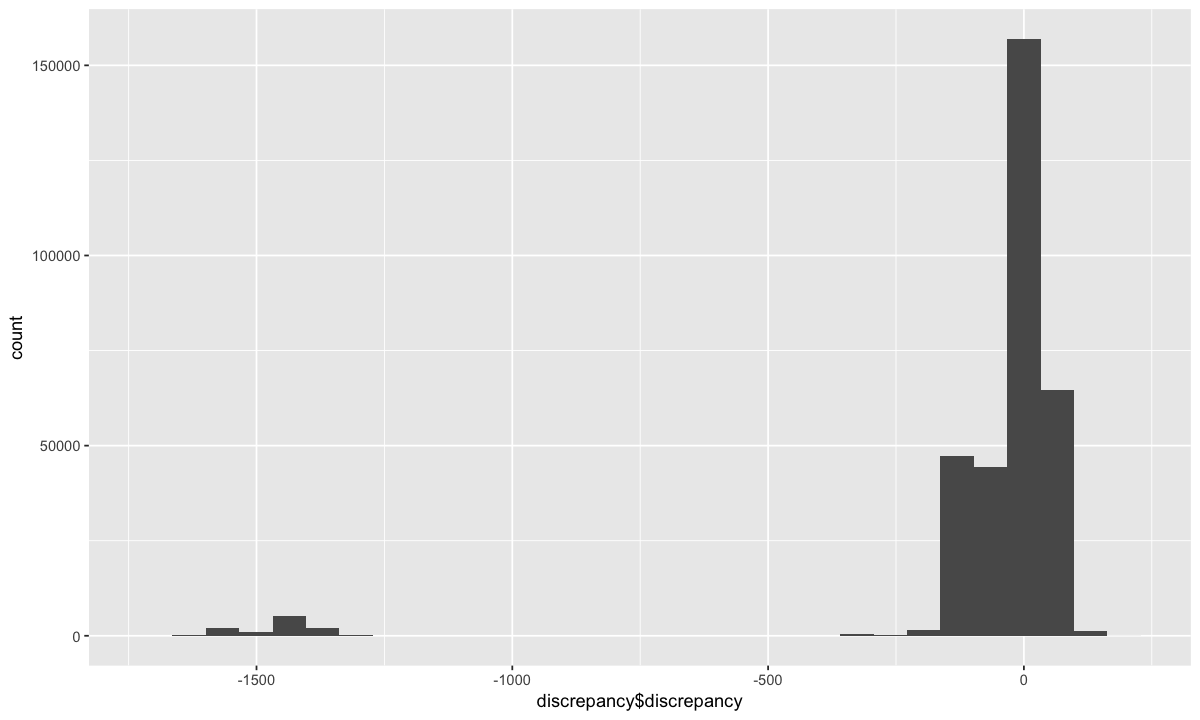

In [29]:
qplot(discrepancy$discrepancy, geom="histogram")  # shortcut ggplot function

This looks like a mixture distribution. Any ideas what could be the cause?

In [30]:
filter(my_flights_total, total_time < -1000) %>% select(dep_time, arr_time) %>% print

# A tibble: 10,621 x 2
   dep_time arr_time
      <int>    <int>
 1     1929        3
 2     1939       29
 3     2058        8
 4     2102      146
 5     2108       25
 6     2120       16
 7     2121        6
 8     2128       26
 9     2134       20
10     2136       25
# ... with 10,611 more rows


We can fix the negative values by adding 24\*60 to them (we keep the positive values as is).

Note that `transmute()` will only keep the new variables.

In [31]:
transmute(my_flights_total, arr_time, dep_time,
          new_total_time = ifelse(
              total_time < 0,
              (total_time + 24*60), + 
               total_time)
          ) %>% print

# A tibble: 336,776 x 3
   arr_time dep_time new_total_time
      <int>    <int>          <dbl>
 1      830      517            193
 2      850      533            197
 3      923      542            221
 4     1004      544            260
 5      812      554            138
 6      740      554            106
 7      913      555            198
 8      709      557             72
 9      838      557            161
10      753      558            115
# ... with 336,766 more rows


Note the use of the `ifelse()` function here. It takes three arguments: a logical (`TRUE`/`FALSE`), plus two other vectors, all having the same length:
```{r}
ifelse(v1, v2, v3)
```
It returns a new vector, also of the same length. Any entry for which `v1==TRUE`, it contains the corresponding entry from `v2`. Otherwise, the entry comes from `v3`.

In [112]:
v1 = c(1,3,3,5,6)
v2 = c(5,8,-1,0,3)
# ifelse(v1 > v2, v1, v2)
# c(5, 8, 3, 5, 6)
pmax(v1, v2)

[1] 5 8 3 5 6

### Challenge problem 3
For each $i = 1,2,3,\dots,1000$ (the first 1000 natural numbers), let
- $x_i = 3$ if $i$ is even; and
- $x_i = 2i$ if $i$ is odd.

What is $x_1 + x_2 + \cdots + x_{1000}$?

In [117]:
i = 1:1000
is_even = i %% 2 == 0

ifelse(
    is_even,
    3,
    2 * i
)

[1]  2  3  6  3 10  3

A nice feature of `mutate()`/`transmute()` is that you can use columns defined earlier in the command:

In [34]:
print(mutate(flights, gain = arr_delay - dep_delay, 
                      gain_per_hour = gain / (air_time / 60)))

# A tibble: 336,776 x 21
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# ... with 336,766 more row

## Grouped Summaries
`summarize()` can be used to summarize entire data frames by collapsing them into single number summaries. As opposed to `mutate()`, which generates a new column and entry for each row, `summarize()` first groups columns and then applies a summary function.

The most basic use of summarize is to compute statistics over the whole data set:

In [121]:
# summarize(flights, delay = mean(dep_delay, na.rm=T)) %>% print
mean(flights$dep_delay, na.rm=TRUE)

[1] 12.63907

Here we used the `na.rm=TRUE` option to tell R to ignore entries with missing `dep_delay` when calculating the mean. If we did not do this we would get `NA`s:

In [36]:
summarize(flights, delay = mean(dep_delay, na.rm = FALSE))  # the default

  delay
1 NA   

`na.rm=TRUE` is equivalent to dropping the missing entries and then calculating the mean:

In [37]:
filter(flights, !is.na(dep_delay)) %>% summarize(delay=mean(dep_delay))

  delay   
1 12.63907

### Grouping observations
`summarize()` is most useful when combined with `group_by()` to group observations before calculating the summary statistic. The `group_by` function tells R how your data are grouped:

In [125]:
# flights %>% group_by(year, month) %>% print
by_month <- group_by(flights, year, month)

In [126]:
summarize(by_month, mean_dep_delay=mean(dep_delay, na.rm=T)) %>% print

# A tibble: 12 x 3
# Groups:   year [?]
    year month mean_dep_delay
   <int> <int>          <dbl>
 1  2013     1          10.0 
 2  2013     2          10.8 
 3  2013     3          13.2 
 4  2013     4          13.9 
 5  2013     5          13.0 
 6  2013     6          20.8 
 7  2013     7          21.7 
 8  2013     8          12.6 
 9  2013     9           6.72
10  2013    10           6.24
11  2013    11           5.44
12  2013    12          16.6 


Many summary functions are available:

* Center: `mean(), median()`
* Spread: `sd(), IQR(), mad()`
* Range: `min(), max(), quantile()`
* Position: `first(), last(), nth()`
* Count: `n(), n_distinct()`
* Logical: `any(), all()`

### Examples
Compute the number of flights each month:

In [128]:
group_by(flights, month) %>% summarize(n())

   month n()  
1   1    27004
2   2    24951
3   3    28834
4   4    28330
5   5    28796
6   6    28243
7   7    29425
8   8    29327
9   9    27574
10 10    28889
11 11    27268
12 12    28135

### Always include counts
This operation is so common that we have a special shortcut for it:

In [143]:
baseball = tbl_df(Lahman::battingStats())
baseball %>% group_by(playerID) %>% 
             summarize(mba=mean(BA, na.rm=T), n=n()) %>% 
             filter(n>5) %>% 
             arrange(desc(mba)) %>% print

# A tibble: 6,935 x 3
   playerID    mba     n
   <chr>     <dbl> <int>
 1 campsh01  1        11
 2 lyonbr01  1        13
 3 meekev01  1         6
 4 rodried01 1         7
 5 yanes01   1        13
 6 clarkte01 0.75      9
 7 callami01 0.667     6
 8 brittza01 0.625     6
 9 tomlijo01 0.6       7
10 tsaoch01  0.577     6
# ... with 6,925 more rows


One of the reasons for the `count()` shortcut is that it is always a good idea to add counts when do you a summary. This is because some groups may have very low numbers of observations, resulting in high variance for the summary statistics. For example, let's look at particular airplanes which have high delays, perhaps due to maintenance, etc:

In [145]:
not_cancelled = flights %>% filter(!is.na(dep_delay), !is.na(arr_delay))
not_cancelled %>% group_by(tailnum) %>% summarise(delay = mean(arr_delay)) %>% top_n(5)

Selecting by delay


  tailnum delay
1 N587NW  264  
2 N844MH  320  
3 N851NW  219  
4 N911DA  294  
5 N922EV  276  

The top five most delayed planes experience an average delay of 4-5 hours! Clearly this is not realistic. The issue is that there are very few observations for each of these planes:

In [146]:
delays = not_cancelled %>% group_by(tailnum) %>% summarise(delay=mean(arr_delay), obs=n())
top_n(delays, 5, delay)

  tailnum delay obs
1 N587NW  264   1  
2 N844MH  320   1  
3 N851NW  219   1  
4 N911DA  294   1  
5 N922EV  276   1  

### Challenge problem 4
Which plane (tail number) flew the most flights in July?

In [148]:
flights %>% filter(month == 7) %>% count(tailnum) %>% top_n(5)

Selecting by n


  tailnum n  
1 N298JB   76
2 N711MQ   69
3 N721MQ   69
4 N735MQ   67
5 NA      281

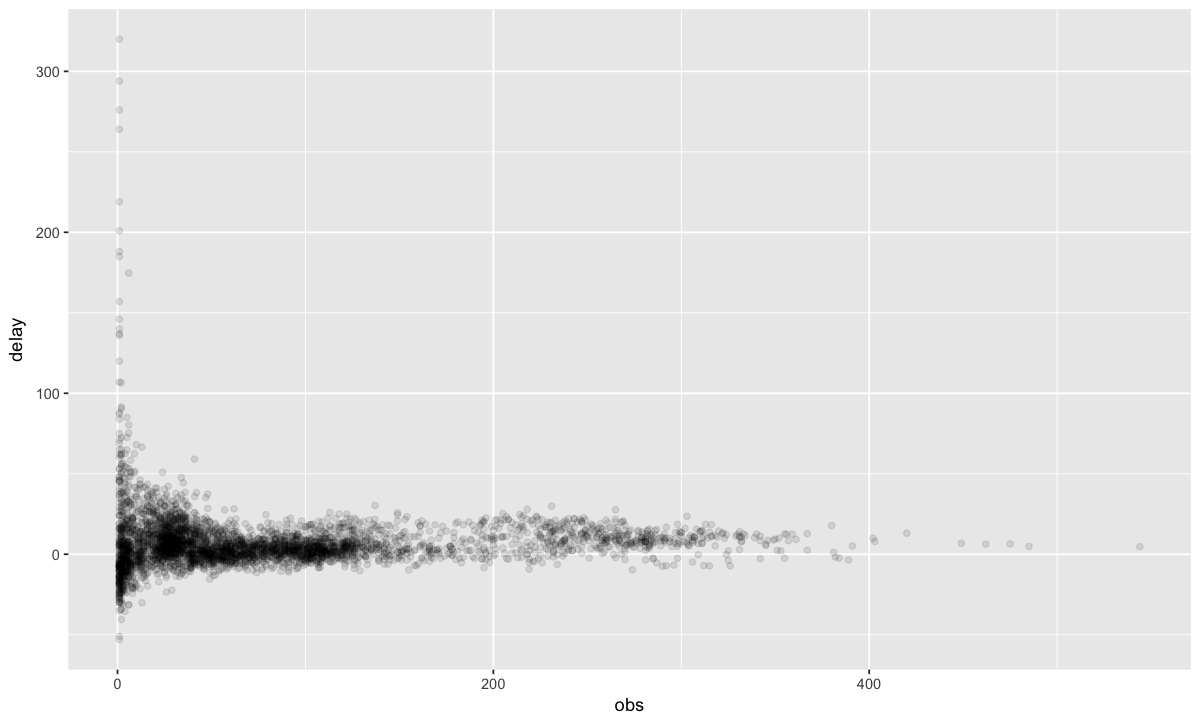

In [45]:
ggplot(delays) + geom_point(aes(x=obs, y=delay), alpha=.1) 

The solution is to filter to only those planes that had sufficiently many observations:

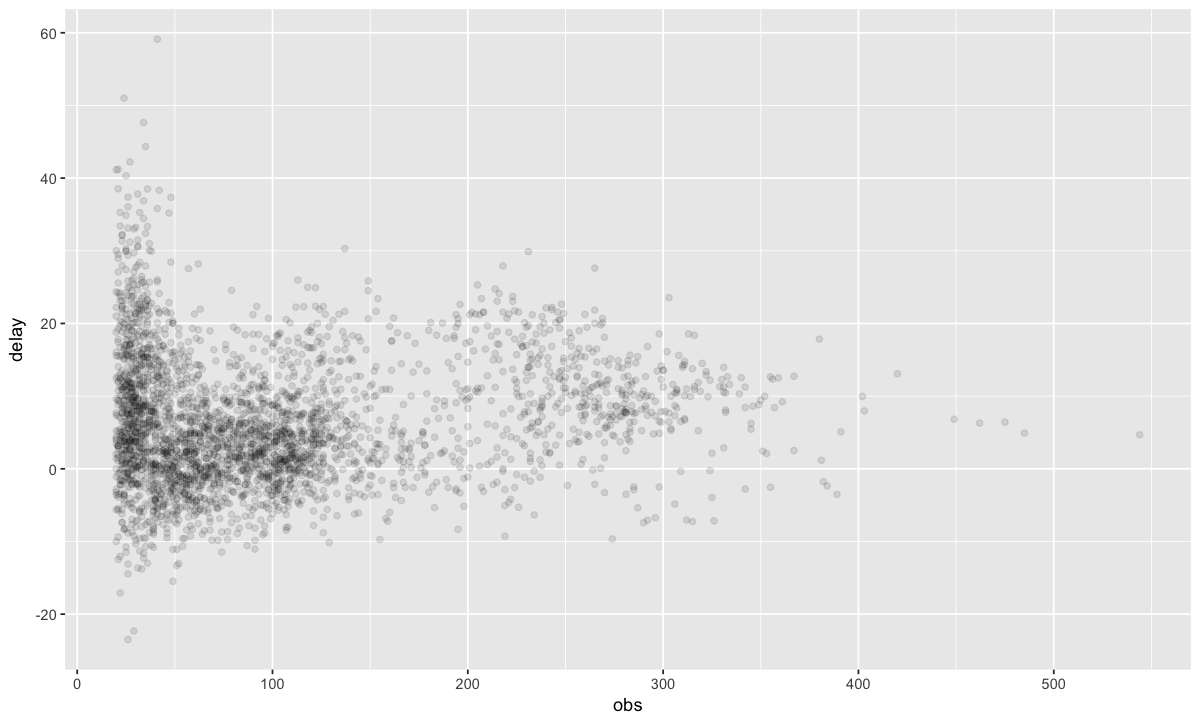

In [46]:
ggplot(filter(delays, obs >= 20)) + geom_point(aes(x=obs, y=delay), alpha=.1) 

Something similar occurs if we start sorting by an average: ignoring the standard error of the estimated average can cause spurious extreme values to rise to the top. Here's an example from baseball:

`geom_smooth()` using method = 'gam'


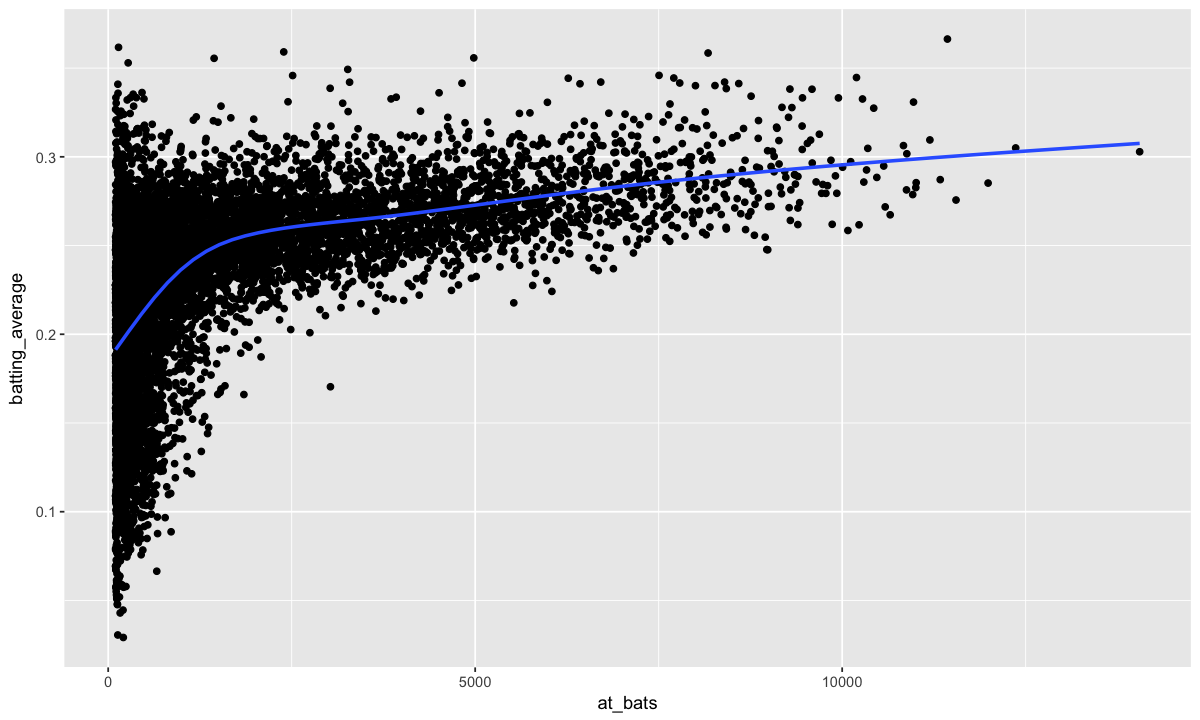

In [47]:
# Convert to a tibble so it prints nicely
# H = hits; AB = at bats
# ba =
batters <- as_tibble(Lahman::Batting) %>% group_by(playerID) %>% summarise(
    batting_average = sum(H, na.rm = TRUE) / sum(AB, na.rm = TRUE),
    at_bats = sum(AB, na.rm = TRUE) )
batters %>% filter(at_bats > 100) %>%
            ggplot(mapping = aes(x = at_bats, y = batting_average)) + 
                  geom_point() + geom_smooth(se = FALSE)

Clearly better players get more at-bats. Who are the best players? If we sort by batting average, we see:

In [48]:
batters %>% arrange(desc(batting_average)) %>% print

# A tibble: 18,915 x 3
   playerID  batting_average at_bats
   <chr>               <dbl>   <int>
 1 abramge01               1       1
 2 banisje01               1       1
 3 bartocl01               1       1
 4 bassdo01                1       1
 5 berrijo01               1       1
 6 birasst01               1       2
 7 bruneju01               1       1
 8 burnscb01               1       1
 9 cammaer01               1       1
10 campsh01                1       1
# ... with 18,905 more rows


To get a better estimate we should restrict to people who had at least 100 at-bats, say:

In [49]:
batters %>% arrange(desc(batting_average)) %>% filter(at_bats >= 1000) %>% print

# A tibble: 3,693 x 3
   playerID  batting_average at_bats
   <chr>               <dbl>   <int>
 1 cobbty01            0.366   11434
 2 barnero01           0.359    2392
 3 hornsro01           0.358    8173
 4 jacksjo01           0.356    4981
 5 meyerle01           0.356    1443
 6 odoulle01           0.349    3264
 7 delahed01           0.346    7505
 8 mcveyca01           0.346    2513
 9 speaktr01           0.345   10195
10 willite01           0.344    7706
# ... with 3,683 more rows


In [50]:
Lahman::playerInfo("cobbty01")

     playerID nameFirst nameLast
3183 cobbty01 Ty        Cobb    

### Some other examples of aggregation
Compute the number of unique destinations for each day of the month:

In [51]:
group_by(flights, day) %>% summarize(n_distinct(dest)) %>% print

# A tibble: 31 x 2
     day `n_distinct(dest)`
   <int>              <int>
 1     1                 96
 2     2                101
 3     3                 97
 4     4                 96
 5     5                100
 6     6                 99
 7     7                 96
 8     8                 95
 9     9                101
10    10                 97
# ... with 21 more rows


Dispersion of departure delays by carrier:

In [52]:
group_by(flights, carrier) %>% summarize(n=n(),
                                         dep_iqr=IQR(dep_delay, na.rm=T), 
                                         arr_iqr=IQR(arr_delay, na.rm=T)) %>% arrange(n)

   carrier n     dep_iqr arr_iqr
1  OO         32 13      22.00  
2  HA        342  6      30.50  
3  YV        601 30      40.25  
4  F9        685 22      40.00  
5  AS        714 10      34.00  
6  FL       3260 21      31.00  
7  VX       5162 12      31.00  
8  WN      12275 19      30.00  
9  9E      18460 23      36.00  
10 US      20536  7      23.00  
11 MQ      26397 16      31.00  
12 AA      32729 10      29.00  
13 DL      48110 10      28.00  
14 EV      54173 30      40.00  
15 B6      54635 17      31.00  
16 UA      58665 15      30.00  

What is the worst-performing air carrier (in terms of departure delay) for each month of the year?

In [53]:
most_delayed = group_by(flights, carrier, month) %>% 
                   summarize(mean_dep_delay=mean(dep_delay, na.rm=T), obs=n()) %>%
                   group_by(month) %>% mutate(rank=min_rank(-mean_dep_delay)) %>%
                   arrange(month, rank) %>% filter(rank==1) %>% print

# A tibble: 12 x 5
# Groups:   month [12]
   carrier month mean_dep_delay   obs  rank
   <chr>   <int>          <dbl> <int> <int>
 1 OO          1           67       1     1
 2 F9          2           29.8    49     1
 3 YV          3           31.9    18     1
 4 YV          4           27.1    38     1
 5 F9          5           35.9    58     1
 6 OO          6           61       2     1
 7 FL          7           41.2   263     1
 8 OO          8           64       4     1
 9 FL          9           16.9   255     1
10 YV         10           20      66     1
11 FL         11           16.9   202     1
12 EV         12           27.9  4307     1


### Challenge problem 5
Let's say an air carrier is *regional* if its average distance traveled per flight is less than 600 miles, with a standard deviation of less than 250 miles. Which of these carriers are regional?

In [54]:
flights %>% group_by(carrier) %>% 
            summarize(mu=mean(distance), sigma=sd(distance), count=n()) %>%
            filter(mu < 600, sigma < 250)

  carrier mu       sigma    count
1 MQ      569.5327 226.2287 26397
2 OO      500.8125 206.1722    32
3 YV      375.0333 159.7196   601

Again note the issue here with low observation counts. In case you are curious what these carrier codes represent (who not to fly), we can use a *table join* (to be discussed later) to figure it out:

In [55]:
most_delayed %>% left_join(airlines)

Joining, by = "carrier"


   carrier month mean_dep_delay obs  rank name                       
1  OO       1    67.00000          1 1    SkyWest Airlines Inc.      
2  F9       2    29.77083         49 1    Frontier Airlines Inc.     
3  YV       3    31.88889         18 1    Mesa Airlines Inc.         
4  YV       4    27.11111         38 1    Mesa Airlines Inc.         
5  F9       5    35.94828         58 1    Frontier Airlines Inc.     
6  OO       6    61.00000          2 1    SkyWest Airlines Inc.      
7  FL       7    41.16270        263 1    AirTran Airways Corporation
8  OO       8    64.00000          4 1    SkyWest Airlines Inc.      
9  FL       9    16.94882        255 1    AirTran Airways Corporation
10 YV      10    20.00000         66 1    Mesa Airlines Inc.         
11 FL      11    16.86634        202 1    AirTran Airways Corporation
12 EV      12    27.88718       4307 1    ExpressJet Airlines Inc.   

How does the situation change if we look at the median departure delay?

In [56]:
group_by(flights, carrier, month) %>% 
    summarize(median_dep_delay=median(dep_delay, na.rm=T), obs=n()) %>%
    group_by(month) %>% mutate(rank=min_rank(-median_dep_delay)) %>%
    arrange(month, rank) %>% filter(rank==1) %>% print

# A tibble: 12 x 5
# Groups:   month [12]
   carrier month median_dep_delay   obs  rank
   <chr>   <int>            <dbl> <int> <int>
 1 OO          1             67       1     1
 2 EV          2              1    3827     1
 3 YV          3             15.5    18     1
 4 YV          4              9      38     1
 5 F9          5             13.5    58     1
 6 OO          6             61       2     1
 7 F9          7             16      58     1
 8 OO          8             56       4     1
 9 F9          9              2      58     1
10 FL         10              3     236     1
11 FL         11              6     202     1
12 WN         12              9    1099     1


Compared to the mean, the median departure delay looks less extreme.

### Transformations in summaries
We can combine transformations and summaries to get perform more complicated queries on the data. The following summary looks at the number of early-morning departures by month:

In [57]:
not_cancelled %>% group_by(month) %>% summarise(n_early = sum(dep_time < 500)) %>% print

# A tibble: 12 x 2
   month n_early
   <int>   <int>
 1     1      75
 2     2      84
 3     3     147
 4     4     148
 5     5     120
 6     6     219
 7     7     268
 8     8     135
 9     9      64
10    10      43
11    11      46
12    12     127


A red-eye (overnight) flight will have `dep_time > arr_time`. Here are the red-eyes by month:

In [58]:
not_cancelled %>% group_by(month) %>% summarise(n_redeye = sum(dep_time > arr_time)) %>% print

# A tibble: 12 x 2
   month n_redeye
   <int>    <int>
 1     1      713
 2     2      631
 3     3      949
 4     4     1019
 5     5      795
 6     6     1241
 7     7     1439
 8     8      933
 9     9      489
10    10      507
11    11      657
12    12     1163
